In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device for Train : {device}")

Device for Train : cpu


In [4]:
import os

In [5]:
os.listdir('./')

['.ipynb_checkpoints',
 '1. 무성의모델_학습(0131).ipynb',
 '무성의모델_검증(0127).ipynb',
 '무성의모델학습데이터(0131).xlsx']

In [20]:
data = pd.read_csv('무성의모델학습데이터(0131).csv')
data

,conts,label
0,자기소개요??? 딱히 할 말이 없는데요 잘 모르겠어요 음음 ㅋㅋ,0
1,하하라라한사라라라라라안녕하세요? 좋은하루되세요 전 가요오옹##,0
2,인상좋음나는대학졸업후사진작갈활동하며수많은연예인을찍었다성실하고착한성품을지녰다,0
3,2남1녀중장남조묭한여자가좋음만나면즇은이미지로사길것임니다,0
4,다여님 아 그리고 이 책은 물론 이 모든 것을 다 같이 보내드립니다 수 있는 것입니...,0
...,...,...
63902,INTP-T 소개글 크게 의미 없는 것 같아서 요것만..,0
63903,인상좋음나는대학졸업후사진작갈활동하며수많은연예인을찍었다성실하고착한성품을지녰다,0
63904,다륒다릐다리다뤼 아픙✌️🍿🥲🥲😭😭😭😭😭ㅌ😱😱😱😱😱😱😱😱😱😱😱,1
63905,ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ솔찍히 재혼은 잘모르겠고 좋은인연됬으면 좋겠습니다,1


In [21]:
mu_df = data.copy()

In [22]:
mu_df = mu_df.drop_duplicates()

In [23]:
mu_df.isnull().sum()

conts    0
label    0
dtype: int64

In [24]:
mu_df.reset_index(drop=True, inplace=True)

In [25]:
label_0 = mu_df.loc[mu_df['label']==0]
label_1 = mu_df.loc[mu_df['label']==1]

print(label_0.shape, label_1.shape)

final_mu_df = pd.concat([label_0, label_1]).reset_index(drop=True)

(32845, 2) (30873, 2)


In [26]:
# 학습 데이터 : 검증 데이터 8:2

train_data = final_mu_df.sample(frac=0.8, random_state=2022)[['conts','label']]
test_data = final_mu_df.drop(train_data.index)[['conts','label']]

print(train_data.shape, test_data.shape)

(50974, 2) (12744, 2)


In [27]:
model_name = 'beomi/KcELECTRA-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [28]:
# train dataset 토크나이징
tokenized_train_sentence = tokenizer(
    list(train_data['conts']),
    max_length=128,
    return_tensors='pt',  #pyotorch의 tensor 형태로 return
    padding=True,        #제로패딩 설정
    truncation=True,     # max_length 초과 토큰 truncate
    add_special_tokens=True)  # special token 추가


print(tokenized_train_sentence[0])
print(tokenized_train_sentence[0].tokens)
print(tokenized_train_sentence[0].ids)
print(tokenized_train_sentence[0].attention_mask)

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '저', '##랑', '딸', '둘이', '##살아', '##요', '그리고', '젓', '##즤', '##어머니', '##는', '다른', '##곳', '##사', '##세요', '##ㅎ', '저', '##흐', '##딸', '##도', '저도', '맑', '##답니다', '##ㅎ', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [29]:
# test dataset 토크나이징
tokenized_test_sentence = tokenizer(
    list(test_data['conts']),
    max_length=128,
    return_tensors='pt',
    padding=True,
    truncation=True,
    add_special_tokens=True)

In [30]:
print(tokenized_test_sentence[0])
print(tokenized_test_sentence[0].tokens)
print(tokenized_test_sentence[0].ids)
print(tokenized_test_sentence[0].attention_mask)

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '자기', '##소', '##개', '##요', '?', '?', '?', '딱히', '할', '말이', '없는데', '##요', '잘', '모르겠', '##어요', '음', '##음', 'ㅋㅋ', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

In [31]:
class CustomDataset(torch.utils.data.Dataset) :
    def __init__(self, encodings, labels) :
        self.encodings = encodings
        self.labels = labels
        
    def __len__(self) :
        return len(self.labels)    
        
    def __getitem__(self, idx) :
        item = {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [32]:
# dataset 형성(텐서로 변환)
train_label = train_data['label'].values
test_label = test_data['label'].values

train_dataset = CustomDataset(tokenized_train_sentence, train_label)
test_dataset = CustomDataset(tokenized_test_sentence, test_label)

In [33]:
# 사전학습 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [34]:
# train option setting
train_arguments = TrainingArguments(
                    output_dir='./',
                    num_train_epochs=5,
                    per_device_train_batch_size=64,
                    per_device_eval_batch_size=64,
                    logging_dir='./logs',
                    logging_steps=500,
                    save_total_limit=2)

In [35]:
# metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score


def compute_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision = precision_score(labels, preds) 
    recall = recall_score(labels, preds)
    f1 = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy' : acc,
        'f1' : f1,
        'precision' : precision,
        'recall' : recall
    }

In [36]:
%%time

# Train
train = Trainer(
                model=model,
                args=train_arguments,
                train_dataset=train_dataset,
                eval_dataset=test_dataset,
                compute_metrics=compute_metrics)

train.train()

***** Running training *****
  Num examples = 50974
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 3985


Step,Training Loss
500,0.137100
1000,0.100500
1500,0.091500
2000,0.075100
2500,0.064500
3000,0.049600
3500,0.039400


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500\config.json
Model weights saved in ./checkpoint-500\pytorch_model.bin
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000\config.json
Model weights saved in ./checkpoint-1000\pytorch_model.bin
Saving model checkpoint to ./checkpoint-1500
Configuration saved in ./checkpoint-1500\config.json
Model weights saved in ./checkpoint-1500\pytorch_model.bin
Deleting older checkpoint [checkpoint-500] due to args.save_total_limit
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpoint-2000\config.json
Model weights saved in ./checkpoint-2000\pytorch_model.bin
Deleting older checkpoint [checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to ./checkpoint-2500
Configuration saved in ./checkpoint-2500\config.json
Model weights saved in ./checkpoint-2500\pytorch_model.bin
Deleting older checkpoint [checkpoint-1500] due to args.save_total_limit


CPU times: total: 4d 17h 2min 38s
Wall time: 18h 51min 53s


TrainOutput(global_step=3985, training_loss=0.07462743282916405, metrics={'train_runtime': 67913.039, 'train_samples_per_second': 3.753, 'train_steps_per_second': 0.059, 'total_flos': 1.67647786699008e+16, 'train_loss': 0.07462743282916405, 'epoch': 5.0})

In [37]:
train.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 12744
  Batch size = 64


Trainer is attempting to log a value of "(0.957675402897607, 0.9516337754771919, 0.9546450304259634, None)" of type <class 'tuple'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.18784427642822266,
 'eval_accuracy': 0.9561362209667295,
 'eval_f1': (0.957675402897607, 0.9516337754771919, 0.9546450304259634, None),
 'eval_precision': 0.957675402897607,
 'eval_recall': 0.9516337754771919,
 'eval_runtime': 1196.4661,
 'eval_samples_per_second': 10.651,
 'eval_steps_per_second': 0.167,
 'epoch': 5.0}

### `1차`

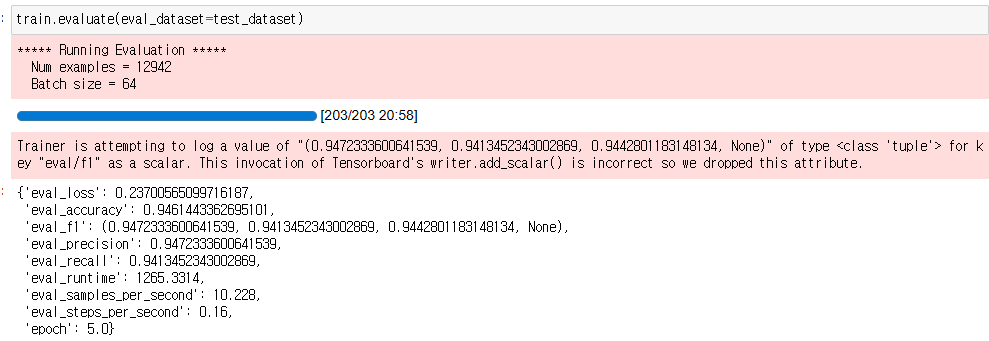

### `2차`

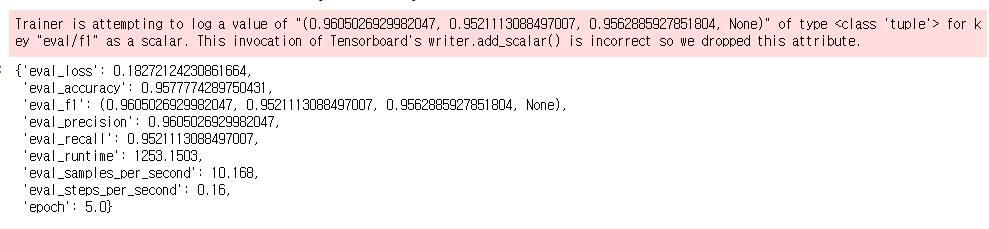

### `3차`

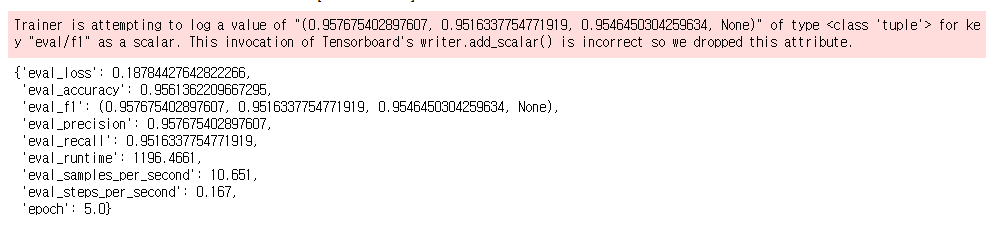

In [45]:
import re

class predictModel() :

    def __init__(self, model_path):
        # load model
        self.model_path = model_path
        self.model = torch.load(model_path)
        # set device
        self.device = torch.device('cpu')
        # load tokenizer
        model_name = 'beomi/KcELECTRA-base'
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def predict_sentence(self, sent):
        self.model.eval()
#         sent = self.clean_sentence(sent)
        # tokenizing
        tokenized_sent = self.tokenizer(
            sent,
            return_tensors='pt',
            truncation=True,
            add_special_tokens=True,
            max_length=128
        )
        tokenized_sent.to(self.device)

        # prediction
        with torch.no_grad():
            outputs = self.model(
                input_ids=tokenized_sent['input_ids'],
                attention_mask=tokenized_sent['attention_mask'],
                token_type_ids=tokenized_sent['token_type_ids']
            )

        # result
        if len(sent) < 10 :
            # 10자 이하는 연락처 로 탐지하지 않음
            return 0

        result = outputs[0].detach().cpu().argmax(-1)
        #     print(outputs[0].detach().cpu())

        return int(result)
        # 0 : 정상, 1 : ( 무성의 or 연락처 탐지 )

In [46]:
from datetime import datetime

today = str(datetime.today())[:10]
path = f"{today}_mu_model.pt"

# save model 
torch.save(model, path)

In [47]:
from datetime import datetime

today = str(datetime.today())[:10]
path = f"{today}_mu_model.pt"

# save model 
torch.save(model, path)

In [48]:
# load model
mod = torch.load(f"{today}_mu_model.pt")
mod.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

------